In [1]:
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import magicsoup as ms
from magicsoup.util import rand_genome
from magicsoup.examples.default import MOLECULES, ACTIONS, DOMAINS

In [2]:
def prot_dom_stats(len_range, genetics: ms.Genetics):
    genomes = [rand_genome(len_range) for _ in range(100)]
    protstats = []
    domstats = []
    for genome in genomes:
        proteins = genetics.get_proteome(genome)
        protstats.append(len(proteins))
        if len(proteins) > 0:
            domstats.extend([len(d.domains) for d in proteins])
    return protstats, domstats

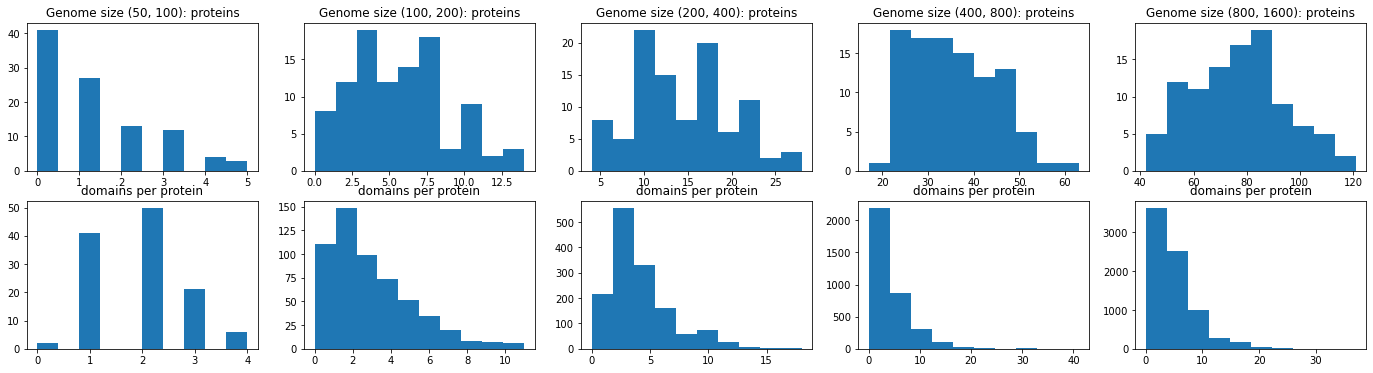

In [3]:
genetics = ms.Genetics(domain_map=DOMAINS)
sizes = [(50, 100), (100, 200), (200, 400), (400, 800), (800, 1600)]
fig, axs = plt.subplots(2, len(sizes), figsize=(24, 6))

for idx, size in enumerate(sizes):
    n_prots, n_doms = prot_dom_stats(size, genetics)
    axs[0, idx].title.set_text(f"Genome size {size}: proteins")
    axs[0, idx].hist(n_prots)
    axs[1, idx].title.set_text(f"domains per protein")
    axs[1, idx].hist(n_doms)

In [4]:
def plot_proteomes(proteome, ax, col_map, val_map, scale_n=100, scale_w=5):
    edges = []
    edge_cols = []
    ws = []
    for idx, prot in enumerate(proteome):
        name = f"P{idx}"
        for dom in prot.domains:
            if dom.signal.is_molecule:
                if dom.is_receptor:
                    edge = ("e" + dom.signal.name, name, dom.weight)
                else:
                    edge = (name, "i" + dom.signal.name, dom.weight)
            else:
                edge = (name, "a" + dom.signal.name, dom.weight)
            edge_cols.append(plt.cm.bwr(dom.weight))
            ws.append(abs(dom.weight) * scale_w)
            edges.append(edge)

    G = nx.DiGraph()
    G.add_weighted_edges_from(edges)
    pos = nx.spring_layout(G, k=1)

    node_cols = [col_map[val_map.get(d[0], "protein")] for d in G]
    node_sizes = [4 * scale_n if d[0] == "P" else 1 * scale_n for d in G]
    nx.draw(
        G, pos,
        node_size=node_sizes,
        node_color=node_cols,
        edge_color=edge_cols,
        connectionstyle="arc3,rad=0.1",
        ax=ax
    )

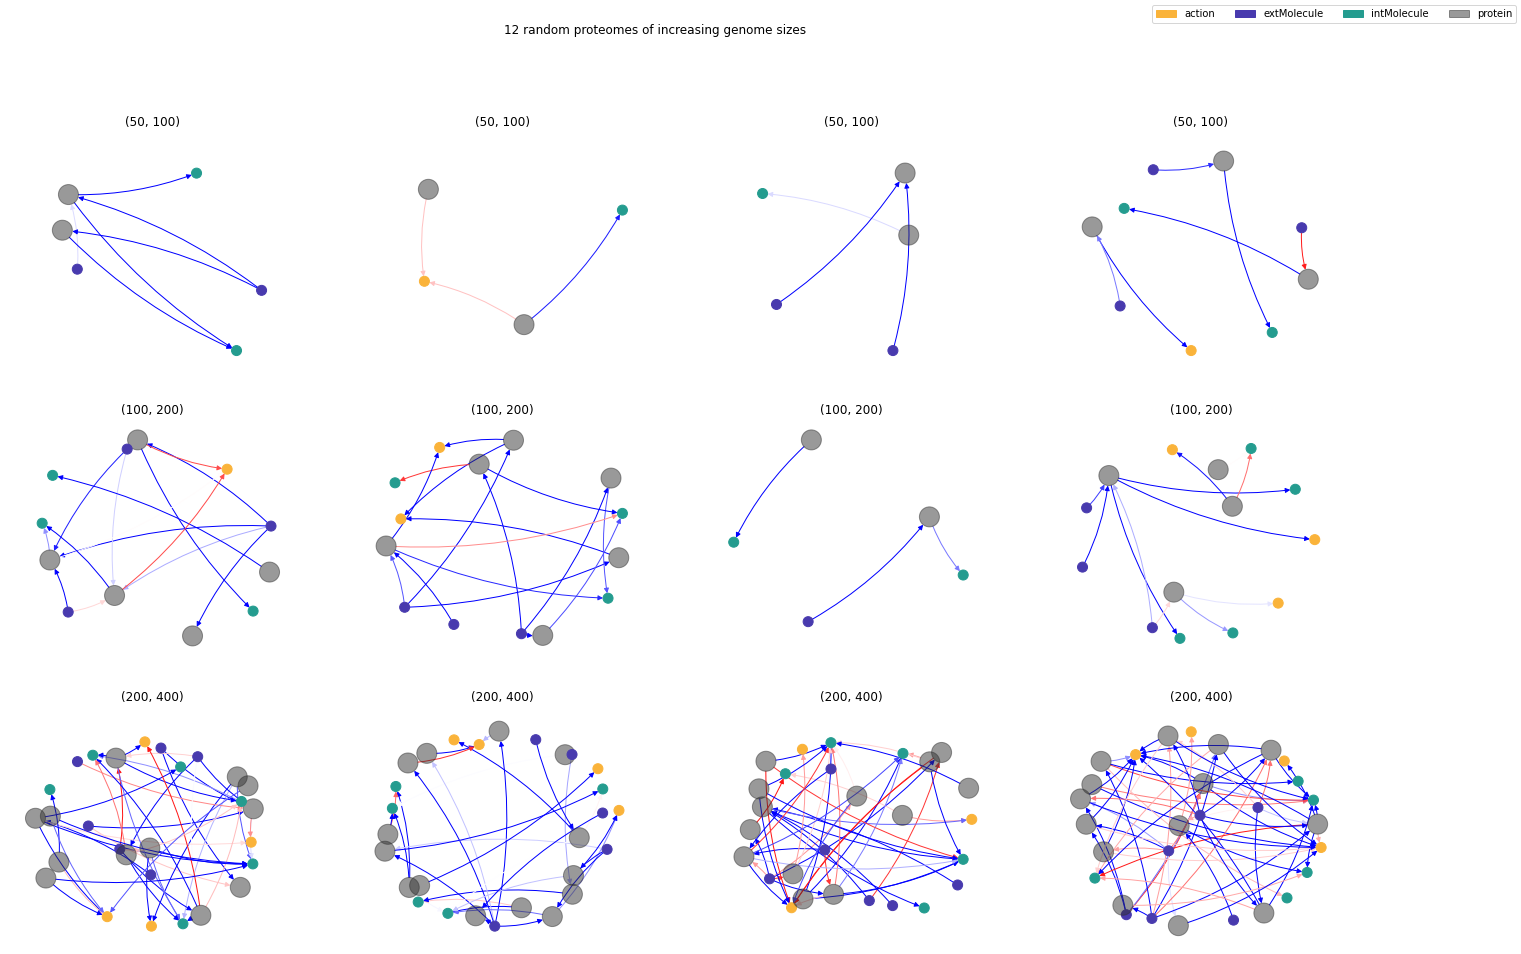

In [5]:
n_cols = 4
n_rows = 3

vmap = {"a": "action", "e": "extMolecule", "i": "intMolecule"}
cmap = {
    "action": "#FAB33A",
    "extMolecule": "#483AAE",
    "intMolecule": "#249C8F",
    "protein": "#3030307d"
}

fig, axs = plt.subplots(n_rows, n_cols, sharey=True, sharex=True, figsize=(24, 15))
fig.suptitle(f"{n_rows * n_cols} random proteomes of increasing genome sizes")
patches = [mpatches.Patch(color=v, label=k) for k, v in cmap.items()]
fig.legend(handles=patches, ncol=len(patches), loc="upper right")

size_range = (50, 100)
for row_i in range(n_rows):
    for col_i in range(n_cols):
        ax = axs[row_i, col_i]
        plotted = False
        while not plotted:
            genome = rand_genome(size_range)
            proteome = genetics.get_proteome(genome)
            if len(proteome) > 1:
                plot_proteomes(proteome, ax, cmap, vmap)
                plotted = True
        axs[row_i, col_i].title.set_text(size_range)
    size_range = tuple(d * 2 for d in size_range)

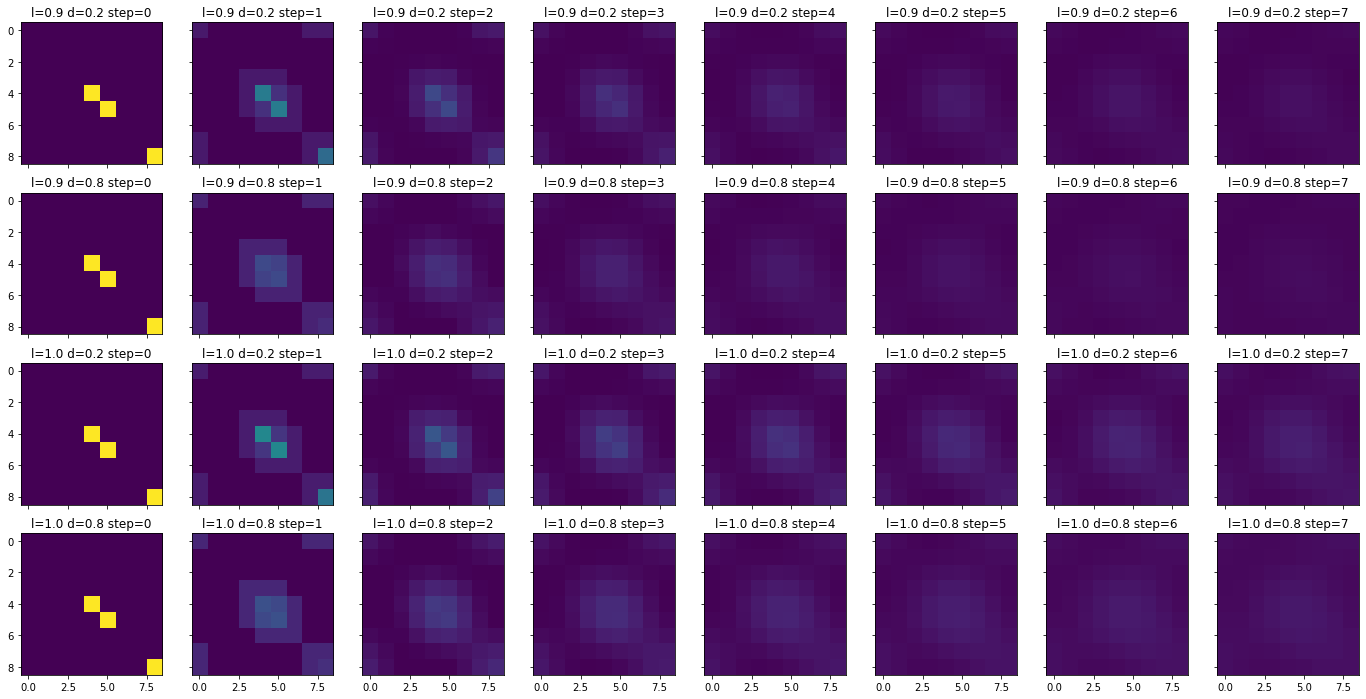

In [6]:
n_steps = 8
diffs = [0.2, 0.8]
lambdas = [0.9, 1.0]

n_rows = len(diffs) * len(lambdas)
fig, axs = plt.subplots(n_rows, n_steps, sharey=True, sharex=True, figsize=(n_steps * 3, n_rows * 3))
for row_i, (l, d) in enumerate(product(lambdas, diffs)):
    world = ms.World(map_size=9, molecules=MOLECULES[:1], actions=[], mol_diff_rate=d, mol_degrad=l, mol_map_init="zeros")
    world.molecule_map[0, 4, 4] = 1.0
    world.molecule_map[0, 5, 5] = 1.0
    world.molecule_map[0, 8, 8] = 1.0
    for step_i in range(n_steps):    
        axs[row_i, step_i].imshow(world.molecule_map[0], interpolation='nearest', vmin=0, vmax=1)
        axs[row_i, step_i].title.set_text(f"l={l:.1f} d={d:.1f} step={step_i}")
        world.diffuse_molecules()
        world.degrade_molecules()

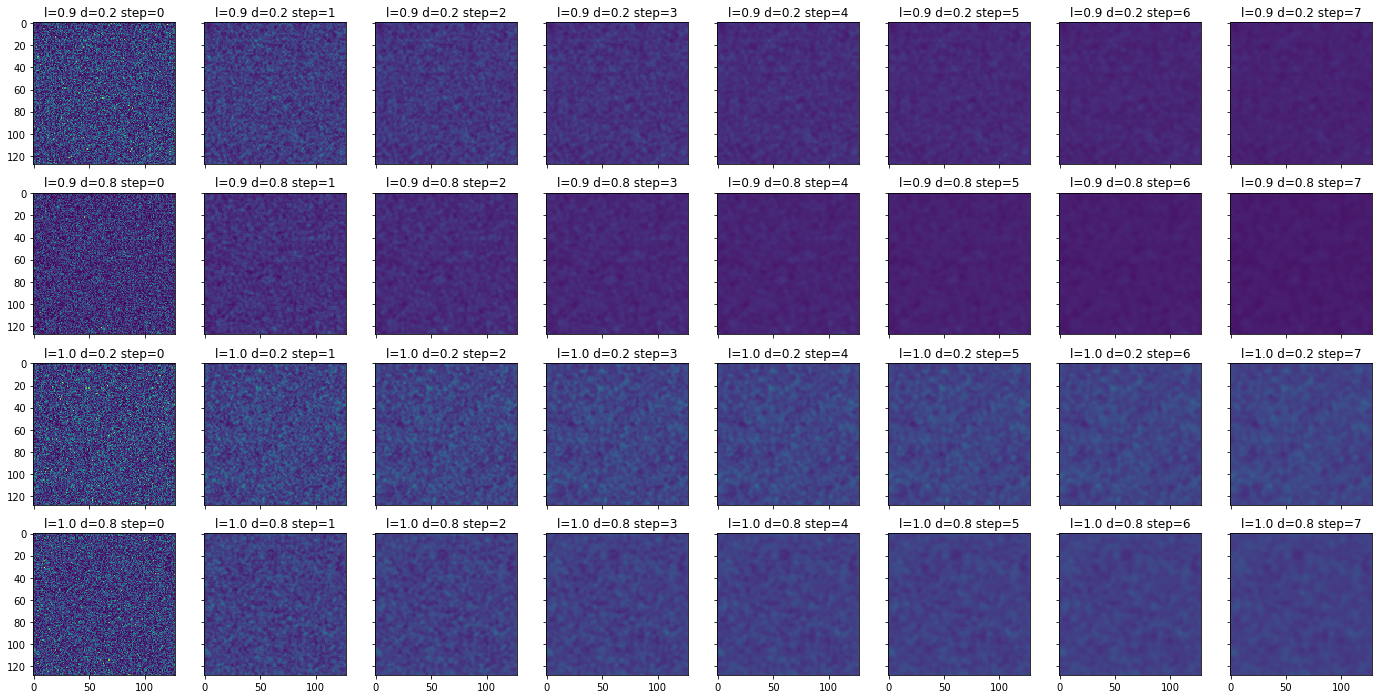

In [10]:
n_steps = 8
diffs = [0.2, 0.8]
lambdas = [0.9, 1.0]

n_rows = len(diffs) * len(lambdas)
fig, axs = plt.subplots(n_rows, n_steps, sharey=True, sharex=True, figsize=(n_steps * 3, n_rows * 3))
for row_i, (l, d) in enumerate(product(lambdas, diffs)):
    world = ms.World(molecules=MOLECULES[:1], actions=[], mol_diff_rate=d, mol_degrad=l)
    max_s = world.molecule_map[0].max()
    for step_i in range(n_steps):    
        axs[row_i, step_i].imshow(world.molecule_map[0], interpolation='nearest', vmin=0, vmax=max_s)
        axs[row_i, step_i].title.set_text(f"l={l:.1f} d={d:.1f} step={step_i}")
        world.diffuse_molecules()
        world.degrade_molecules()

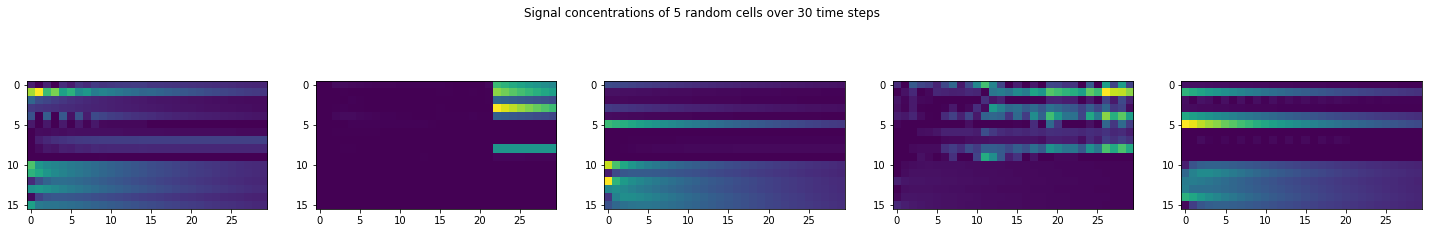

In [8]:
n_cells = 5
n_steps = 30

gs = [rand_genome((1000, 5000)) for _ in range(n_cells)]
ps = [genetics.get_proteome(seq=d) for d in gs]

world = ms.World(molecules=MOLECULES, actions=ACTIONS, mol_degrad=0.95, mol_diff_rate=0.2)
world.add_cells(genomes=gs)
A, B, Z = world.get_cell_params(proteomes=ps)

stack = []
for _ in range(n_steps):
    X = world.get_signals()
    stack.append(X)
    Xd = world.integrate_signals(X=X, A=A, B=B, Z=Z)
    X = X + Xd
    world.update_signals(X=X)
    world.diffuse_molecules()
    world.degrade_molecules()

fig, axs = plt.subplots(1, n_cells, figsize=(n_cells * 5, 4))
fig.suptitle(f"Signal concentrations of {n_cells} random cells over {n_steps} time steps")
signals = torch.stack(stack)
for cell_i in range(n_cells):
    max_s = signals[:, cell_i, :].max()
    axs[cell_i].imshow(signals[:, cell_i, :].T, interpolation='nearest', vmin=0, vmax=max_s)